In [1]:
import ensaio
import pandas as pd

fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126
...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870


In [2]:
import pyproj

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

coordinates = (easting, northing, data.height_geometric_m.values)

In [3]:
import harmonica as hm

eqs_first_guess = hm.EquivalentSources(depth=1e3, damping=1)
eqs_first_guess.fit(coordinates, data.gravity_disturbance_mgal)

EquivalentSources(damping=1, depth=1000.0)

In [4]:
import numpy as np
import verde as vd

score_first_guess = np.mean(
    vd.cross_val_score(
        eqs_first_guess,
        coordinates,
        data.gravity_disturbance_mgal,
    )
)
score_first_guess

np.float64(0.8027851941632995)

In [5]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

In [6]:
import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]


In [7]:
equivalent_sources = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    equivalent_sources.set_params(**params)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            data.gravity_disturbance_mgal,
        )
    )
    scores.append(score)
scores

[np.float64(0.9150928326897354),
 np.float64(0.9142249773025007),
 np.float64(0.9043905752276522),
 np.float64(0.8822529497599797),
 np.float64(0.9158120453861851),
 np.float64(0.9179260104390551),
 np.float64(0.9104311266648011),
 np.float64(0.8751298775892267),
 np.float64(0.9161113383638325),
 np.float64(0.9197261730846333),
 np.float64(0.90702616597728),
 np.float64(0.8619681875562746),
 np.float64(0.9158209704190459),
 np.float64(0.9172918887155358),
 np.float64(0.8946173275890278),
 np.float64(0.8408182949960263)]

In [8]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Score with defaults:", score_first_guess)
print("Best parameters:", parameter_sets[best])

Best score: 0.9197261730846333
Score with defaults: 0.8027851941632995
Best parameters: {'damping': 1, 'depth': 10000.0}


In [9]:
eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, data.gravity_disturbance_mgal
)

In [10]:
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=2e3,
    extra_coords=2.5e3,
)

grid_first_guess = eqs_first_guess.grid(grid_coords)
grid = eqs_best.grid(grid_coords)

In [11]:
 import pygmt

 # Needed so that displaying works on jupyter-sphinx and sphinx-gallery at
 # the same time. Using PYGMT_USE_EXTERNAL_DISPLAY="false" in the Makefile
 # for sphinx-gallery to work means that fig.show won't display anything here
 # either.
 pygmt.set_display(method="notebook")

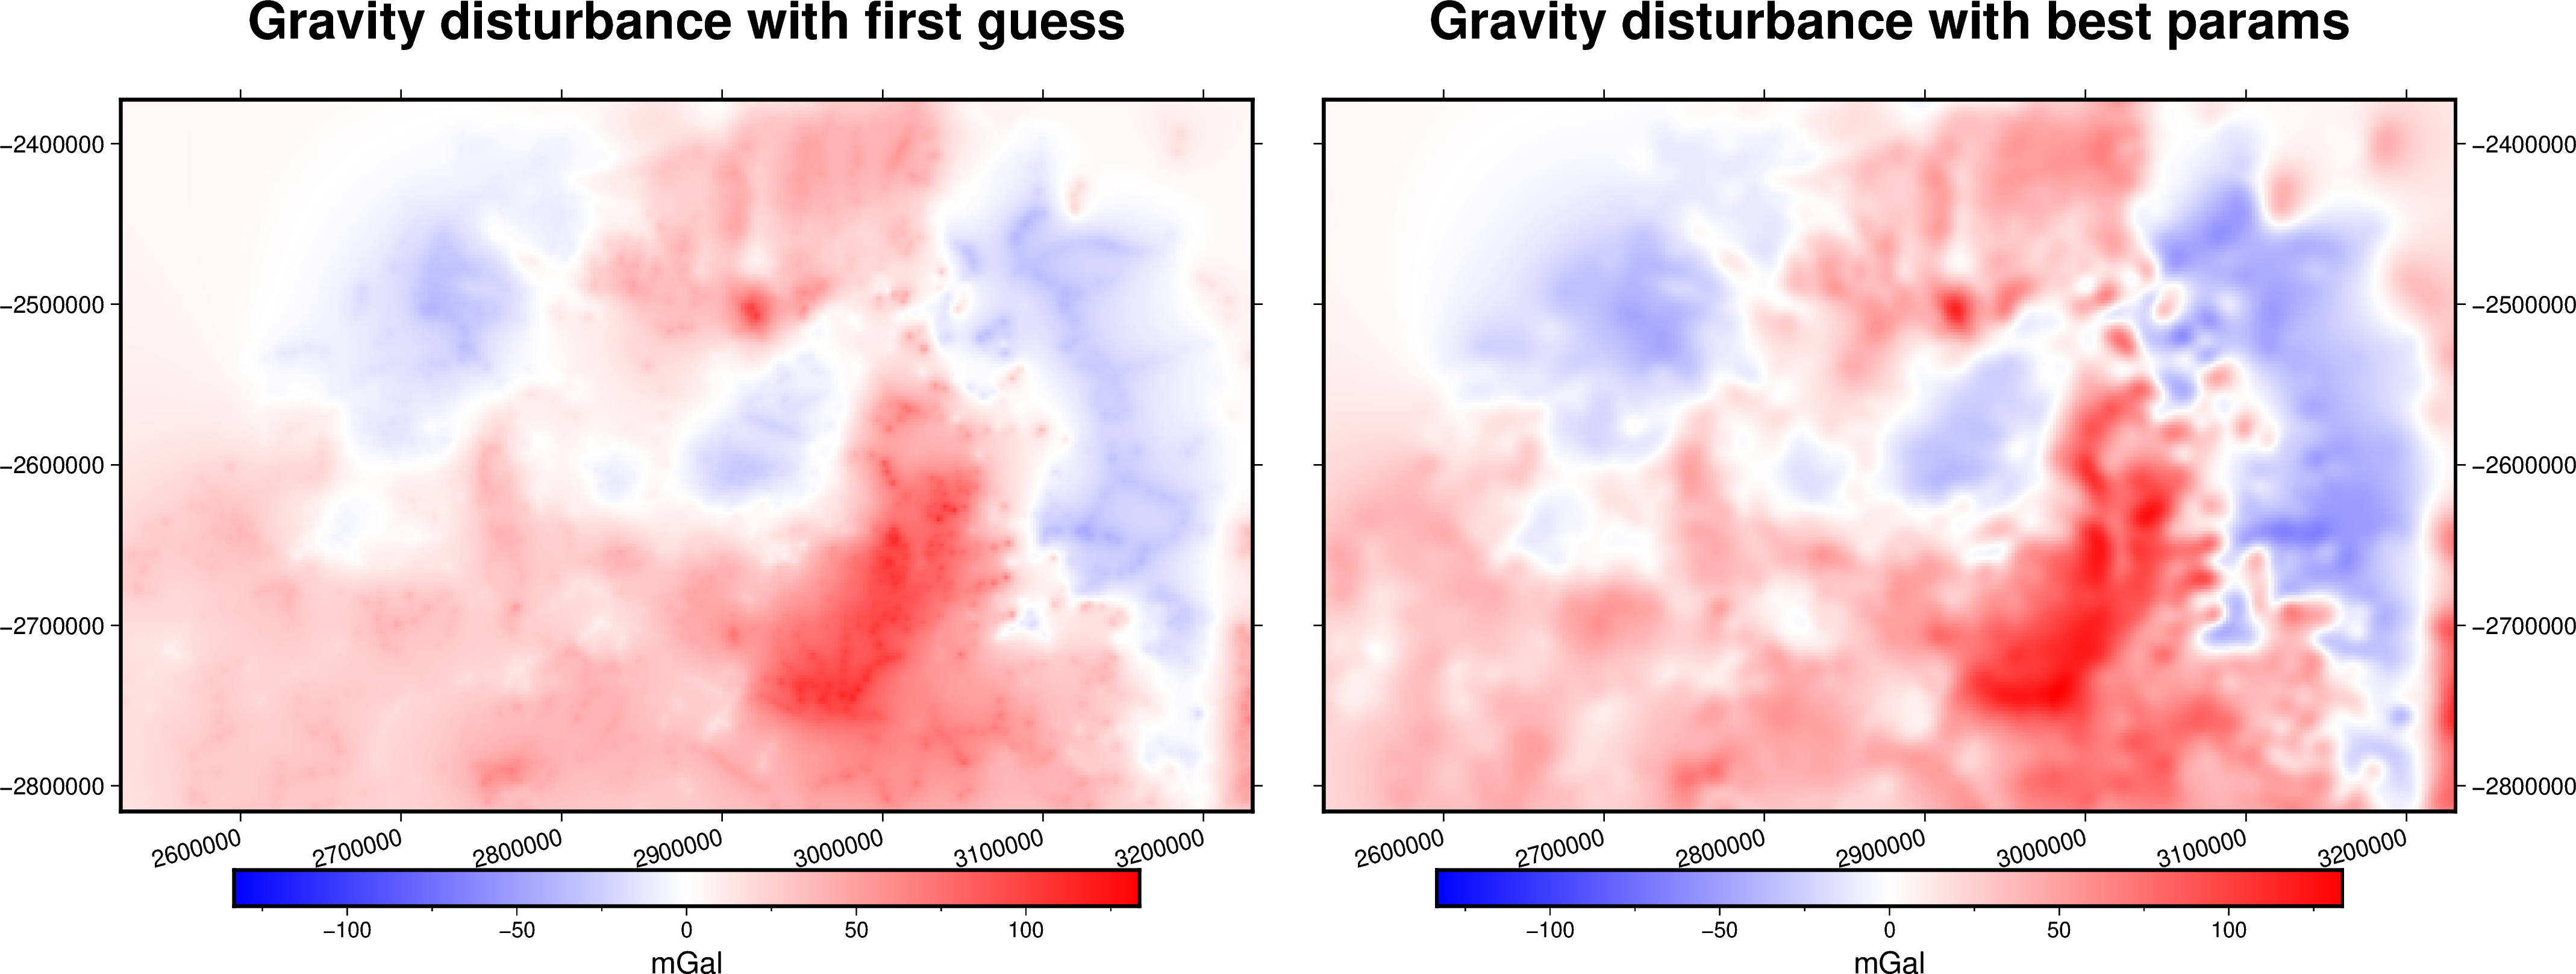

In [12]:
import pygmt

# Set figure properties
w, e, s, n = region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

maxabs = vd.maxabs(grid_first_guess.scalars, grid.scalars)

fig = pygmt.Figure()

# Make colormap of data
pygmt.makecpt(cmap="polar+h0",series=(-maxabs, maxabs,))

title = "Gravity disturbance with first guess"

fig.grdimage(
   projection=fig_proj,
   region=region,
   frame=[f"WSne+t{title}", "xa100000+a15", "ya100000"],
   grid=grid_first_guess.scalars,
   cmap=True,
)
fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

title = "Gravity disturbance with best params"

fig.grdimage(
   frame=[f"ESnw+t{title}", "xa100000+a15", "ya100000"],
   grid=grid.scalars,
   cmap=True,
)
fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.show()